# <center>DataLab Cup 2: CNN for Object Detection</center>
<center>
        Shan-Hung Wu & DataLab
        <br>
        Fall 2018
</center>

# Competition Info
In this competition, you have to train a model that recognize objects in an image. Your goal is to output bounding boxes for objects.
## Problem description
Given an image(shape = [undefined, undefined, 3]), you need to output bounding box ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, class_label) for objects showed in image and its class.([picture source](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/object_localization_and_detection.html))
<img src = 'https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/more_images/LocalizationDetection.png'>


## Data provided
### Dataset: [pascal voc 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)
the dataset contains 20 classes. The train/val data has 9,963  images containing 24,640 annotated objects. We have preprocessed training dataset(4974) and testing dataset(4901 images) for you. You can download them on [kaggle](https://www.kaggle.com/t/858d2036161f4be8a18ee010bc7f7aab)

In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

### Processed data format
The information for each image of training data are recorded in `VOCdevkit_train/VOC2007/Annotations`. However, we have precessed those files for you into one record file: `pascal_voc_training_data.txt` in which each line records informations of each training images.

The data format of pascal_voc_training_data is:
> image_name &nbsp;&nbsp;{xmin_i &nbsp;&nbsp;  ymin_i &nbsp;&nbsp;  xmax_i  &nbsp;&nbsp; ymax_i  &nbsp;&nbsp; class_i}&nbsp;(repeat number of objects times)

Elements are separated by space.

In [2]:
training_data_file = open("./data/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


As you can see, one image may have multiple objects. Another thing to note is, the heights and widths of the images in this datset are different. Therefore, you are suggested to reshape images and ground truth bounding boxes' coordinates into same size.

In this competition, you can implement all kinds of object detection models (R-CNN, Fast-RCNN, Faster-RCNN, YOLOs, SSD,...etc.). However, here we provide a simple template based on [YOLO(You Only Look Once)](https://pjreddie.com/media/files/papers/yolo.pdf) without andy convolutinal layers implemented(this is your mission if you use this template).

In [3]:
import os
import math
import random
import cv2
import numpy as np
import tensorflow as tf
import re
import sys
import time

#if you have multiple GPU on the machine, choose only one to use on this notebook
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#let the gpu allocates memory space dynamically
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import matplotlib.pyplot as plt
%matplotlib inline

/home/hcgogogo/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Dataset Loader
We define a class especially to process training data, reading the records from `pascal_voc_training_data.txt` and follow the steps below to prepare data for our network:
1. Create Dataset using tensorflow data API
2. In Dataset map function, read images and do preprocessing(ex. resizing , normalization)
3. In Dataset map function, change box information `[xmin, ymin, xmax, ymax]` coordinates into `[xcenter, ycenter, width, height]` attributes, which is easier for YOLO model to use.
4. Shuffle, Repeat, Batch operations.
5. Create Dataset Iterator and the session for this loader

In [4]:
class DatasetRunner:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self, common_params, dataset_params):
        
        self.width = common_params['image_size']
        self.height = common_params['image_size']
        self.batch_size = common_params['batch_size']
        self.num_classes = common_params['num_classes']
        self.data_path = dataset_params['path']
        self.thread_num = dataset_params['thread_num']
        self.image_dir = dataset_params['image_dir']
        
        self.max_objects = common_params['max_objects_per_image']
            
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph, config=config)
        
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(self.data_path, 'r')
        
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, self.max_objects))
            if len(self.record_list[-1])<self.max_objects*5:
                self.record_list[-1] = self.record_list[-1] +\
                [float(0), float(0), float(0), float(0), float(0)]*\
                (self.max_objects-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1])>self.max_objects*5:
                self.record_list[-1] = self.record_list[-1][:self.max_objects*5]

        self.build_train_data_tensor()
            
    def build_train_data_tensor(self):
        
        def data_generator(image_name, raw_labels, object_num):
            image_file = tf.read_file(self.image_dir+image_name)
            image = tf.image.decode_jpeg(image_file, channels=3)

            h = tf.shape(image)[0]
            w = tf.shape(image)[1]

            width_rate = self.width * 1.0 / tf.cast(w, tf.float32) 
            height_rate = self.height * 1.0 / tf.cast(h, tf.float32) 

            image = tf.image.resize_images(image, size=[self.height,self.width])
            
            raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
            
            xmin = raw_labels[:, 0]
            ymin = raw_labels[:, 1]
            xmax = raw_labels[:, 2]
            ymax = raw_labels[:, 3]
            class_num = raw_labels[:, 4]
            
            xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
            ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate
            
            box_w = (xmax - xmin) * width_rate
            box_h = (ymax - ymin) * height_rate
            
            labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)

            return image, labels, tf.cast(object_num, tf.int32)
            

        with self.graph.as_default():
            
            dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                          np.array(self.record_list), 
                                                          np.array(self.object_num_list)))

            dataset = dataset.map(data_generator, num_parallel_calls = self.thread_num)
            dataset = dataset.batch(self.batch_size)
            dataset = dataset.shuffle(self.batch_size) 
            dataset = dataset.repeat()

            self.iterator = tf.data.Iterator.from_structure(dataset.output_types)  
            self.data_init_op = self.iterator.make_initializer(dataset)

            self.sess.run(self.data_init_op)
            self.iterate_op = self.iterator.get_next()
            
    def batch(self):
        images, labels, objects_num = self.sess.run(self.iterate_op)

        if objects_num.shape[0] < self.batch_size:
            images, labels, objects_num = self.sess.run(self.iterate_op)
        
        images = images/255 * 2 - 1
        
        return images, labels, objects_num
        
        
    def __del__(self):
        self.close()

    def close(self):

        self.sess.close()
        

Now we can simply new a `DatasetRunner` which can provide batches of training data for our model. 

## Object Detection Model (YOLO)

Different from Region Proposal based model, YOLO devide an image into cell_size$\times$cell_size (say 7$\times$7) cells, each has fixed number of output prediction boxes(coordinates, class_number, and confidence score). The final prediction would be the boxes with highest confidence score. The prediction of YOLO can be based on the output features extracted by the convolutional layers on the input image, which is actually "look once" on each image.
<img src = './img_src/yolo_abstract.png' width = '60%'>

### Intersection Over Union(IoU)
The loss calculation of [YOLO](https://pjreddie.com/media/files/papers/yolo.pdf) includes calculating the intersection over union between the predicted boxes and the ground truth boxes. IoU is a common way to evaluate whether the predicted box coordinate is precise enough or not. The calcuation of iou is 


$$Predicted\_Box\cap GroundTruth\_Box \over{Predicted\_Box\cup GroundTruth\_Box}$$
<img src = './img_src/iou.png' width = '20%'>

So we would like our prediction's IoU with ground the larger the better. In addition, IoU are also used when we evaluate an object detection model is good or not: the prediction is success if the IoU of the predicted box and the ground truth is larger than a threshould.

In [5]:
class YoloTinyNet(object):

    def __init__(self, common_params, net_params, test=False):
        """
        common params: a params dict
        net_params   : a params dict
        """
        #pretrained variable collection
        self.pretrained_collection = []
        #trainable variable collection
        self.trainable_collection = []
         
        #process params
        self.image_size = int(common_params['image_size'])
        self.num_classes = int(common_params['num_classes'])
        self.cell_size = int(net_params['cell_size'])
        self.boxes_per_cell = int(net_params['boxes_per_cell'])
        self.batch_size = int(common_params['batch_size'])
        self.weight_decay = float(net_params['weight_decay'])

        if not test:
            self.object_scale = float(net_params['object_scale'])
            self.noobject_scale = float(net_params['noobject_scale'])
            self.class_scale = float(net_params['class_scale'])
            self.coord_scale = float(net_params['coord_scale'])
         
    def _variable_on_cpu(self, name, shape, initializer, pretrain=True, train=True):
        """Helper to create a Variable stored on CPU memory.
        Args:
          name: name of the Variable
          shape: list of ints
          initializer: initializer of Variable
        Returns:
          Variable Tensor
        """
        with tf.device('/cpu:0'):
            var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
            if pretrain:
                self.pretrained_collection.append(var)
            if train:
                self.trainable_collection.append(var)
        return var 
    
    def _variable_with_weight_decay(self, name, shape, stddev, wd, pretrain=True, train=True):
        """Helper to create an initialized Variable with weight decay.
        Note that the Variable is initialized with truncated normal distribution
        A weight decay is added only if one is specified.
        Args:
          name: name of the variable 
          shape: list of ints
          stddev: standard devision of a truncated Gaussian
          wd: add L2Loss weight decay multiplied by this float. If None, weight 
          decay is not added for this Variable.
       Returns:
          Variable Tensor 
        """
        var = self._variable_on_cpu(name, shape,
            tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32), pretrain, train)
        if wd is not None:
            weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
            tf.add_to_collection('losses', weight_decay)
        return var 

    def fully(self, scope, input, in_dimension, out_dimension, leaky=True, pretrain=True, train=True):
        """Fully connection layer
        Args:
          scope: variable_scope name
          input: [batch_size, ???]
          out_dimension: int32
        Return:
          output: 2-D tensor [batch_size, out_dimension]
        """
        with tf.variable_scope(scope) as scope:
            reshape = tf.reshape(input, [tf.shape(input)[0], -1])

            weights = self._variable_with_weight_decay('weights', shape=[in_dimension, out_dimension],
                                  stddev=0.04, wd=self.weight_decay, pretrain=pretrain, train=train)
            biases = self._variable_on_cpu('biases', [out_dimension], tf.constant_initializer(0.0), pretrain, train)
            local = tf.matmul(reshape, weights) + biases

            if leaky:
                local = self.leaky_relu(local)
            else:
                local = tf.identity(local, name=scope.name)

        return local
    
    def leaky_relu(self, x, alpha=0.1, dtype=tf.float32):
        """leaky relu 
        if x > 0:
          return x
        else:
          return alpha * x
        Args:
          x : Tensor
          alpha: float, the slope of the leaky function
        Return:
          y : Tensor
        """
        x = tf.cast(x, dtype=dtype)
        
        return tf.nn.leaky_relu(x, alpha=alpha)
    
    def inference(self, images):
        """Build the yolo model
        Input the images, output prediction boxes(center_x, center_y, w, h, scale) and the corresponding classes
        
        Args:
          images:  4-D tensor [batch_size, image_height, image_width, channels]
        Returns:
          predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        """
        images = tf.reshape(images, [-1, self.image_size*self.image_size*3])
        
        #Only Fully connected layer
        fully0 = self.fully('local0', images, self.image_size*self.image_size*3, 256)

        fully1 = self.fully('local1', fully0, 256, 512)

        fully2 = self.fully('local2', fully1, 512, 4096)

        fully3 = self.fully('local3', fully2, 4096, self.cell_size * self.cell_size * 
                            (self.num_classes + self.boxes_per_cell * 5), leaky=False,
                            pretrain=False, train=True)

        n1 = self.cell_size * self.cell_size * self.num_classes

        n2 = n1 + self.cell_size * self.cell_size * self.boxes_per_cell

        class_probs = tf.reshape(fully3[:, 0:n1], (-1, self.cell_size, self.cell_size, self.num_classes))
        scales = tf.reshape(fully3[:, n1:n2], (-1, self.cell_size, self.cell_size, self.boxes_per_cell))
        boxes = tf.reshape(fully3[:, n2:], (-1, self.cell_size, self.cell_size, self.boxes_per_cell * 4))

        predicts = tf.concat([class_probs, scales, boxes], 3)

        return predicts

    def iou(self, boxes1, boxes2):
        """calculate ious
        Args:
          boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
          boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)
          
        Return:
          iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        """
        
        #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
        boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                          boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])
        
        #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
        boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

        boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                          boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

        #calculate the left up point of boxes' overlap area
        lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
        #calculate the right down point of boxes overlap area
        rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

        #intersection
        intersection = rd - lu 

        #the size of the intersection area
        inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]
        
        mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

        #if intersection is negative, then the boxes don't overlap
        inter_square = mask * inter_square

        #calculate the boxs1 square and boxs2 square
        square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
        square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

        return inter_square/(square1 + square2 - inter_square + 1e-6)


    def losses_calculation(self, num, object_num, loss, predict, labels, nilboy):
        """
        calculate loss
        Args:
          predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
          labels : [max_objects, 5]  (x_center, y_center, w, h, class)
        """
        label = labels[num:num+1, :]
        label = tf.reshape(label, [-1])

        #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
        min_x = (label[0] - label[2] / 2) / (self.image_size / self.cell_size)
        max_x = (label[0] + label[2] / 2) / (self.image_size / self.cell_size)

        min_y = (label[1] - label[3] / 2) / (self.image_size / self.cell_size)
        max_y = (label[1] + label[3] / 2) / (self.image_size / self.cell_size)

        min_x = tf.floor(min_x)
        min_y = tf.floor(min_y)

        max_x = tf.minimum(tf.ceil(max_x), self.cell_size)
        max_y = tf.minimum(tf.ceil(max_y), self.cell_size)

        temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
        objects = tf.ones(temp, tf.float32)

        temp = tf.cast(tf.stack([min_y, self.cell_size - max_y, min_x, self.cell_size - max_x]), tf.int32)
        temp = tf.reshape(temp, (2, 2))
        objects = tf.pad(objects, temp, "CONSTANT")

        #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
        #calculate responsible tensor [CELL_SIZE, CELL_SIZE]
        center_x = label[0] / (self.image_size / self.cell_size)
        center_x = tf.floor(center_x)

        center_y = label[1] / (self.image_size / self.cell_size)
        center_y = tf.floor(center_y)

        response = tf.ones([1, 1], tf.float32)

        temp = tf.cast(tf.stack([center_y, self.cell_size - center_y - 1, 
                                 center_x, self.cell_size -center_x - 1]), 
                       tf.int32)
        self.tmp = tf.stack([center_y, self.cell_size - center_y - 1, 
                             center_x, self.cell_size -center_x - 1])
        temp = tf.reshape(temp, (2, 2))
        response = tf.pad(response, temp, "CONSTANT")
        #objects = response

        #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        predict_boxes = predict[:, :, self.num_classes + self.boxes_per_cell:]

        predict_boxes = tf.reshape(predict_boxes, [self.cell_size, 
                                                   self.cell_size, 
                                                   self.boxes_per_cell, 4])

        predict_boxes = predict_boxes * [self.image_size / self.cell_size, 
                                         self.image_size / self.cell_size, 
                                         self.image_size, self.image_size]

        base_boxes = np.zeros([self.cell_size, self.cell_size, 4])

        #for each cell
        for y in range(self.cell_size):
            for x in range(self.cell_size):
                
                base_boxes[y, x, :] = [self.image_size / self.cell_size * x, self.image_size / self.cell_size * y, 0, 0]
                
        base_boxes = np.tile(np.resize(base_boxes, [self.cell_size, self.cell_size, 1, 4]), [1, 1, self.boxes_per_cell, 1])

        #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
        predict_boxes = base_boxes + predict_boxes

        iou_predict_truth = self.iou(predict_boxes, label[0:4])
        #calculate C [cell_size, cell_size, boxes_per_cell]
        C = iou_predict_truth * tf.reshape(response, [self.cell_size, self.cell_size, 1])

        #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        I = iou_predict_truth * tf.reshape(response, (self.cell_size, self.cell_size, 1))

        max_I = tf.reduce_max(I, 2, keep_dims=True)

        I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (self.cell_size, self.cell_size, 1))

        #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        no_I = tf.ones_like(I, dtype=tf.float32) - I 


        p_C = predict[:, :, self.num_classes:self.num_classes + self.boxes_per_cell]

        #calculate truth x, y, sqrt_w, sqrt_h 0-D
        x = label[0]
        y = label[1]

        sqrt_w = tf.sqrt(tf.abs(label[2]))
        sqrt_h = tf.sqrt(tf.abs(label[3]))

        #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        p_x = predict_boxes[:, :, :, 0]
        p_y = predict_boxes[:, :, :, 1]

        #p_sqrt_w = tf.sqrt(tf.abs(predict_boxes[:, :, :, 2])) * ((tf.cast(predict_boxes[:, :, :, 2] > 0, tf.float32) * 2) - 1)
        #p_sqrt_h = tf.sqrt(tf.abs(predict_boxes[:, :, :, 3])) * ((tf.cast(predict_boxes[:, :, :, 3] > 0, tf.float32) * 2) - 1)
        #p_sqrt_w = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 2]))
        #p_sqrt_h = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 3]))
        #p_sqrt_w = predict_boxes[:, :, :, 2]
        #p_sqrt_h = predict_boxes[:, :, :, 3]
        p_sqrt_w = tf.sqrt(tf.minimum(self.image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
        p_sqrt_h = tf.sqrt(tf.minimum(self.image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))
        
        #calculate truth p 1-D tensor [NUM_CLASSES]
        P = tf.one_hot(tf.cast(label[4], tf.int32), self.num_classes, dtype=tf.float32)

        #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
        p_P = predict[:, :, 0:self.num_classes]

        #class_loss
        class_loss = tf.nn.l2_loss(tf.reshape(objects, (self.cell_size, self.cell_size, 1)) * (p_P - P)) * self.class_scale
        #class_loss = tf.nn.l2_loss(tf.reshape(response, (self.cell_size, self.cell_size, 1)) * (p_P - P)) * self.class_scale

        #object_loss
        object_loss = tf.nn.l2_loss(I * (p_C - C)) * self.object_scale
        #object_loss = tf.nn.l2_loss(I * (p_C - (C + 1.0)/2.0)) * self.object_scale

        #noobject_loss
        #noobject_loss = tf.nn.l2_loss(no_I * (p_C - C)) * self.noobject_scale
        noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * self.noobject_scale

        #coord_loss
        coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(self.image_size/self.cell_size)) +
                     tf.nn.l2_loss(I * (p_y - y)/(self.image_size/self.cell_size)) +
                     tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/ self.image_size +
                     tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/self.image_size) * self.coord_scale

        nilboy = I

        return (num + 1, object_num, [loss[0] + class_loss, 
                                      loss[1] + object_loss, 
                                      loss[2] + noobject_loss,
                                      loss[3] + coord_loss], 
                predict, labels, nilboy)

    def loss(self, predicts, labels, objects_num):
        """Add Loss to all the trainable variables
          Args:
          predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
          ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
          labels  : 3-D tensor of [batch_size, max_objects, 5]
          objects_num: 1-D tensor [batch_size]
        """
        def condition(num, object_num, loss, predict, label, nilboy):
            """
            if num < object_num
            """
            return num < object_num
        
        class_loss = tf.constant(0, tf.float32)
        object_loss = tf.constant(0, tf.float32)
        noobject_loss = tf.constant(0, tf.float32)
        coord_loss = tf.constant(0, tf.float32)
        loss = [0, 0, 0, 0]
        for i in range(self.batch_size):
            predict = predicts[i, :, :, :]
            label = labels[i, :, :]
            object_num = objects_num[i]
            nilboy = tf.ones([7,7,2])
            tuple_results = tf.while_loop(condition, self.losses_calculation, 
                                          [tf.constant(0), object_num, 
                                           [class_loss, object_loss, noobject_loss, coord_loss], 
                                           predict, label, nilboy])

            for j in range(4):
                loss[j] = loss[j] + tuple_results[2][j]
            nilboy = tuple_results[5]

        tf.add_to_collection('losses', (loss[0] + loss[1] + loss[2] + loss[3])/self.batch_size)

        tf.summary.scalar('class_loss', loss[0]/self.batch_size)
        tf.summary.scalar('object_loss', loss[1]/self.batch_size)
        tf.summary.scalar('noobject_loss', loss[2]/self.batch_size)
        tf.summary.scalar('coord_loss', loss[3]/self.batch_size)
        tf.summary.scalar('weight_loss', tf.add_n(tf.get_collection('losses')) 
                          - (loss[0] + loss[1] + loss[2] + loss[3])/self.batch_size )

        return tf.add_n(tf.get_collection('losses'), name='total_loss'), nilboy

## Model Runner
Next, we can define a runner object to link the dataset iterator and the network together to run the trainin process.

In [6]:
class YoloRunner(object):

    def __init__(self, dataset, net, common_params, solver_params):
        #process params
        self.learning_rate = float(solver_params['learning_rate'])
        self.moment = float(solver_params['moment'])
        self.batch_size = int(common_params['batch_size'])
        self.height = int(common_params['image_size'])
        self.width = int(common_params['image_size'])
        self.max_objects = int(common_params['max_objects_per_image'])
        self.train_dir = str(solver_params['train_dir'])
        
        if not os.path.exists(self.train_dir):
            os.makedirs(self.train_dir)
        
        self.max_iterators = int(solver_params['max_iterators'])
        self.print_frequency = int(solver_params['print_frequency'])
        self.save_frequency = int(solver_params['save_frequency'])
        #
        self.dataset = dataset
        self.net = net
        #construct graph
        self.construct_graph()
    def _train(self):
        """Train model
        Create an optimizer and apply to all trainable variables.
        Args:
          total_loss: Total loss from net.loss()
          global_step: Integer Variable counting the number of training steps
          processed
        Returns:
          train_op: op for training
        """
        opt = tf.train.MomentumOptimizer(self.learning_rate, self.moment)
        grads = opt.compute_gradients(self.total_loss)

        apply_gradient_op = opt.apply_gradients(grads, global_step=self.global_step)

        return apply_gradient_op

    def construct_graph(self):
        # construct graph
        self.global_step = tf.Variable(0, trainable=False)
        
        self.images = tf.placeholder(tf.float32, (None, self.height, self.width, 3))
        self.labels = tf.placeholder(tf.float32, (None, self.max_objects, 5))
        self.objects_num = tf.placeholder(tf.int32, (None))

        self.predicts = self.net.inference(self.images)
        self.total_loss, self.nilboy = self.net.loss(self.predicts, self.labels, self.objects_num)
        tf.summary.scalar('loss', self.total_loss)
        self.train_op = self._train()

    def run(self):
        saver = tf.train.Saver(self.net.trainable_collection, write_version=tf.train.SaverDef.V2)

        init =  tf.global_variables_initializer()

        summary_op = tf.summary.merge_all()

        sess = tf.Session(config = config)

        sess.run(init)
        
        summary_writer = tf.summary.FileWriter(self.train_dir, sess.graph)

        for step in range(self.max_iterators):
            start_time = time.time()

            np_images, np_labels, np_objects_num = self.dataset.batch()

            _, loss_value, nilboy= sess.run([self.train_op, self.total_loss, self.nilboy], 
                                            feed_dict={self.images: np_images, 
                                                       self.labels: np_labels,
                                                       self.objects_num: np_objects_num})

            duration = time.time() - start_time

            assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

            if step % self.print_frequency== 0:
                num_examples_per_step = self.dataset.batch_size
                examples_per_sec = num_examples_per_step / duration
                sec_per_batch = float(duration)

                format_str = ('step %d, loss = %.2f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (step, loss_value,
                                     examples_per_sec, sec_per_batch))

                sys.stdout.flush()
            if step % self.print_frequency == 0:
                summary_str = sess.run(summary_op, feed_dict={self.images: np_images, 
                                                              self.labels: np_labels, 
                                                              self.objects_num: np_objects_num})
                summary_writer.add_summary(summary_str, step)
            if step % self.save_frequency == 0:
                saver.save(sess, self.train_dir + '/model.ckpt', global_step=step)
        sess.close()

    def prepare_inference(self, model_version):
        saver = tf.train.Saver(self.net.trainable_collection)
        init =  tf.global_variables_initializer()
        
        self.sess = tf.Session(config = config)
        self.sess.run(init)
        
        saver.restore(self.sess, self.train_dir+'/model.ckpt-'+model_version)

    def make_one_prediction(self, images):

        prediction = self.sess.run(self.predicts, feed_dict= {self.images: images})
        
        return prediction

### Hyperparameter Setting

In [7]:
common_params = {
    'image_size': 224,
    'batch_size': 16,
    'num_classes': 20,
    'max_objects_per_image': 20
}
dataset_params = {
    'path': 'data/pascal_voc_training_data.txt',
    'image_dir': './data/VOCdevkit_train/VOC2007/JPEGImages/',
    'thread_num': 5
}
net_params = {
    'weight_decay': 0.0005,
    'cell_size': 7,
    'boxes_per_cell': 2,
    'object_scale': 1,
    'noobject_scale': 0.5,
    'class_scale': 1,
    'coord_scale': 5, 

}
solver_params = {
    'learning_rate': 0.000001,
    'moment': 0.9,
    'max_iterators': 1200,
    'print_frequency': 100,
    'save_frequency' : 1000,
    'train_dir': 'models/yolo-like'
}

## Start Training
Now we can start training our yolo-like model:

In [8]:
tf.reset_default_graph()
sys.path.append('./')

dataset = DatasetRunner(common_params, dataset_params)
net = YoloTinyNet(common_params, net_params)
model_runner = YoloRunner(dataset, net, common_params, solver_params)

model_runner.run()

step 0, loss = 3485.85 (3.8 examples/sec; 4.224 sec/batch)
step 100, loss = 470.23 (56.5 examples/sec; 0.283 sec/batch)
step 200, loss = 243.91 (70.3 examples/sec; 0.228 sec/batch)
step 300, loss = 244.27 (59.4 examples/sec; 0.269 sec/batch)
step 400, loss = 208.01 (55.7 examples/sec; 0.287 sec/batch)
step 500, loss = 149.68 (70.1 examples/sec; 0.228 sec/batch)
step 600, loss = 119.66 (84.7 examples/sec; 0.189 sec/batch)
step 700, loss = 103.05 (62.6 examples/sec; 0.256 sec/batch)
step 800, loss = 101.70 (72.0 examples/sec; 0.222 sec/batch)
step 900, loss = 78.15 (71.4 examples/sec; 0.224 sec/batch)
step 1000, loss = 99.44 (84.3 examples/sec; 0.190 sec/batch)
step 1100, loss = 73.77 (74.7 examples/sec; 0.214 sec/batch)


## Predict Test data
After training, we should run testing on the test data images. Since we should output a txt file in similar format as `pascal_voc_training_data.txt`, we should change the YOLO output box [xcenter, ycenter, width, height] format back to [xmin, ymin, xmax, ymax].
### Process YOLO's predictions
Below is the function process the output of the YOLO network and return the most confident box and its corresponding class and confidence score.

In [9]:
def process_predicts(predicts):
    """
    Process YOLO outputs into bou
    """
    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (net_params['cell_size'], net_params['cell_size'], 1, 20))
    C = np.reshape(C, (net_params['cell_size'], net_params['cell_size'], net_params['boxes_per_cell'], 1))
    
    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (net_params['cell_size'], 
                             net_params['cell_size'], 
                             net_params['boxes_per_cell'], 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (common_params['image_size']/float(net_params['cell_size']))
    ycenter = (index[0] + ycenter) * (common_params['image_size']/float(net_params['cell_size']))

    w = w * common_params['image_size']
    h = h * common_params['image_size']

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

here we want to predict testing data one by one, so we rebuild our network using batch size 1

In [10]:
tf.reset_default_graph()
common_params['batch_size'] = 1
net = YoloTinyNet(common_params, net_params)
solver = YoloRunner(None, net, common_params, solver_params)

### Build Test dataset Iterator

In [11]:
test_img_files = open('data/pascal_voc_testing_data.txt')
test_img_dir = './data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []
img_size = common_params['image_size']

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])
    
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    
    image_file = tf.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)
    
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize_images(image, size=[img_size,img_size])
    
    return image_name, image, h, w
test_dataset = test_dataset.map(load_img_data)
test_iterator = test_dataset.make_one_shot_iterator()
next_test_element = test_iterator.get_next()
tdata_sess = tf.Session(config = config)

### Make Prediction and Output to txt file
To run the evaluation program we provide, you should output your prediction with this format(similar but different with `pascal_voc_training_data.txt`)

> image_name &nbsp;&nbsp;{xmin_i &nbsp;&nbsp;  ymin_i &nbsp;&nbsp;  xmax_i  &nbsp;&nbsp; ymax_i  &nbsp;&nbsp; class_i  &nbsp;&nbsp;  <b>confidence_score</b>}&nbsp;(repeat number of objects times)

for each line in the txt file.

<b>Note</b>: it is also acceptable if there are multiple lines with same image name(different box predictions).

In [13]:
output_file = open('./data/test_predion.txt', 'w')
solver.prepare_inference(model_version = '1000')

while True:
    try:
        img_name, test_img, img_h, img_w = tdata_sess.run(next_test_element)
        test_img = test_img/255 * 2 - 1
        test_img = np.expand_dims(test_img, axis=0)
        y_pred = solver.make_one_prediction(test_img)
        xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)

        xmin, ymin, xmax, ymax = xmin*(img_w/img_size), ymin*(img_h/img_size), xmax*(img_w/img_size), ymax*(img_h/img_size)

        #img filename, (xmin, ymin, xmax, ymax, class, confidence)*number_of_predictions
        output_file.write(img_name.decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
    except tf.errors.OutOfRangeError:
        print("done predicting all test data")
        break
output_file.close()

INFO:tensorflow:Restoring parameters from models/yolo-like/model.ckpt-1000
done predicting all test data


### Run Evaluation Metric
Finally, you can use following example code to run the evaluation program we provide and output the csv file. Please submit the csv file onto [Kaggle](https://www.kaggle.com/t/858d2036161f4be8a18ee010bc7f7aab)

The evaluation program calculates [mean Average Precision(mAP)](https://github.com/Cartucho/mAP) of your output boxes. It will first sort your prediction by your confidence score, and get the Precision/Recall curve:
<img src="https://user-images.githubusercontent.com/15831541/43008995-64dd53ce-8c34-11e8-8a2c-4567b1311910.png" > (img source:[github](https://github.com/Cartucho/mAP))

Then the area under this curve is the mAP of this class.

We separated test data into 10 groups, and calculates the mAP of each class for each group. Your goal is to maximize the total mAP score.

In [14]:
sys.path.insert(0, './evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./data/test_predion.txt', './output_file.csv')

End Evalutation


## Visualization
Here we provide a simple code to draw the predicted bounding box and class onto the image and visualize using matplot.

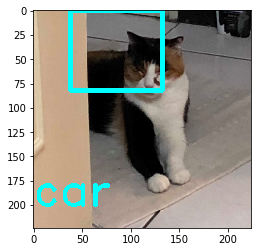

In [28]:
np_img = cv2.imread('./img_src/demo.jpg')
resized_img = cv2.resize(np_img, (common_params['image_size'], common_params['image_size']))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, common_params['image_size'], common_params['image_size'], 3))

y_pred = solver.make_one_prediction(np_img)
xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)

As you can see, the result of current model needs some improvements. After training, your model shall have at least the capability to output prediction like this:
<img src="./img_src/demo_result.png" align="left">


# Other Models
### [Fast-RCNN](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Girshick_Fast_R-CNN_ICCV_2015_paper.pdf)
#### Roi pooling ([api source](https://github.com/deepsense-ai/roi-pooling))

Region of interest pooling (RoI pooling) is an operation widely used in object detecion tasks using convolutional neural networks. It was proposed by Ross Girshick ([paper](https://arxiv.org/pdf/1504.08083.pdf)) and it achieves a significant speedup of both training and testing. It also maintains a high detection accuracy. The layer takes two inputs:

1. A fixed-size feature map obtained from a deep convolutional network with many convolutions and max pooling layers.
2. An N-by-5 matrix of representing a list of regions, where N is a number of RoIs. The first columns represents the image index and the remaining four are the coordinates of the top left and bottom right corners of the region.

<img src = "https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/more_images/RoiPoolingLayer.png" width = "50%">

What does the RoI pooling actually do? For every region of interest from the input list, it takes a section of the input feature map that corresponds to it and scales it to some pre-defined size (e.g., 7×7). The scaling is done by:
1. Dividing the region proposal into equal-sized sections (the number of which is the same as the dimension of the output)
2. Finding the largest value in each section
3. Copying these max values to the output buffer

The result is that from a list of rectangles with different sizes we can quickly get a list of corresponding feature maps with a fixed size. 
<img src = "https://deepsense.ai/wp-content/uploads/2017/02/roi_pooling-1.gif" width = "40%">
(source: [deepsense.ai](https://deepsense.ai/region-of-interest-pooling-explained/))

### [Faster-RCNN](http://www.cvlibs.net/projects/autonomous_vision_survey/literature/Ren2015NIPS.pdf)
The main idea is use the last conv layers to infer region proposals.
Faster-RCNN consists of two modules.
- Region Proposal Network (RPN): Gives a set of rectangles based on deep convolution layer.
- Fast-RCNN RoI Pooling layer: Classify each proposal, and refining proposal location.
<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/more_images/Faster_Rcnn.png" width="50%">

### [SSD](https://arxiv.org/pdf/1512.02325.pdf)
Single-Shot Multi Box Detector is a model based on YOLO, but it has better ability to detect diverse scale objects.
- [reference](https://arxiv.org/abs/1512.02325)

# Precautions
## Scoring and Report
Your score will be part of the final private result on kaggle and part of your report.

Your report(.ipynb file) should have:
- Your code
- What kind of models you have tried and how did they work.
- Anything you've done and want to tell us.
- What problems you occured and how did you solve them.

## What you should NOT do
- Load pretrained model weights directly from other sources.
- Clone other's project from github(You should implement by yourself).
- Plagiarize other team's code.(You'll both get 0 point if we find it)
- Pretrain your network on other version of <b>pascal voc</b> dataset(you can only use the pascal data we provided on kaggle).
- Use the testing groundtruth to generate your output.

## What you can do
- You can pretrain your network on other image dataset such as COCO, ImageNet, ... But you should mention how you process those data and how you pre-train your model in your report.

## Competition timeline
- 2018/11/6 competition announced.
- 2018/11/18 23:59(UTC) competition deadline.
- 2018/11/?? winner team share(will announce afterward).
- 2018/11/22 23:59(TW) report deadline.